In [1]:
import glob
import os
import stingray as st
import numpy as np
from stingray import Lightcurve, AveragedPowerspectrum
from astropy.io import fits
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [12,12]

lc_fnames = ['prev_obs/pps/P0840910501PNX000SRCTSR8001.FTZ']
evt_names = ['prev_obs/0840910501_PN1_evts.fits','prev_obs/0840910501_M11_evts.fits','prev_obs/0840910501_M21_evts.fits']

lcs = []
backlcs = []
slcs = []
hlcs = []
for file in lc_fnames:
    hdul = fits.open(file)
    time = hdul[1].data.field('TIME')
    rate = hdul[1].data.field('RATE')
    backrate = hdul[1].data.field('BACKV')
    err = hdul[1].data.field('ERROR')
    soft = hdul[1].data.field('RATE1') + hdul[1].data.field('RATE2') + hdul[1].data.field('RATE3')
    hard = hdul[1].data.field('RATE4') + hdul[1].data.field('RATE5')
    ers = hdul[1].data.field('RATE1_ERR') + hdul[1].data.field('RATE2_ERR') + hdul[1].data.field('RATE3_ERR')
    erh = hdul[1].data.field('RATE4_ERR') + hdul[1].data.field('RATE5_ERR')
    pn_gtis = []
    max_gti = 0
    for i in hdul[2].data:
        pn_gtis.append([i[0],i[1]])
        if i[1] - i[0] > max_gti:
            max_gti = i[1] - i[0]
    lcs.append(Lightcurve(time, rate, err, gti=pn_gtis, input_counts=False))
    backlcs.append(Lightcurve(time, backrate, err, gti=pn_gtis, input_counts=False))
    slcs.append(Lightcurve(time, soft, ers, gti=pn_gtis, input_counts=False))
    hlcs.append(Lightcurve(time, hard, erh, gti=pn_gtis, input_counts=False))
    
print(max_gti)

14915.520000100136


/home/rwebbe/.local/lib/python3.8/site-packages/stingray/lightcurve.py:520: UserWarning: There are non-finite points in the data, but they are outside GTIs. 
  warnings.warn("There are non-finite points in the data, but they are outside GTIs. ")
/home/rwebbe/.local/lib/python3.8/site-packages/stingray/lightcurve.py:520: UserWarning: There are non-finite points in the data, but they are outside GTIs. 
  warnings.warn("There are non-finite points in the data, but they are outside GTIs. ")
/home/rwebbe/.local/lib/python3.8/site-packages/stingray/lightcurve.py:520: UserWarning: There are non-finite points in the data, but they are outside GTIs. 
  warnings.warn("There are non-finite points in the data, but they are outside GTIs. ")


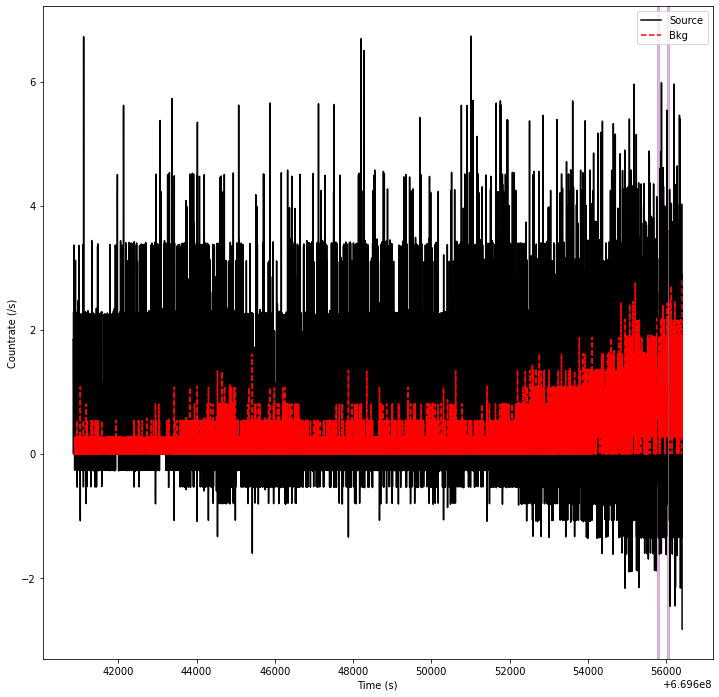

In [2]:
for i in range(len(lcs)):
    plt.xlabel('Time (s)')
    plt.ylabel('Countrate (/s)')
    plt.plot(lcs[i].time, lcs[i].countrate, color='k', ds='steps-mid', label='Source')
    plt.plot(backlcs[i].time, backlcs[i].countrate, color='r', ls='--', ds='steps-mid', label='Bkg')
    plt.legend(loc='upper right')
    for j in range(len(lcs[i].gti)-1):
        plt.axvspan(lcs[i].gti[j][1],lcs[i].gti[j+1][0],color='purple',alpha=0.25)
    plt.show()

/home/rwebbe/.local/lib/python3.8/site-packages/stingray/lightcurve.py:388: RuntimeWarning: invalid value encountered in multiply
  counts = self._countrate * self.dt
1it [00:00, 256.64it/s]


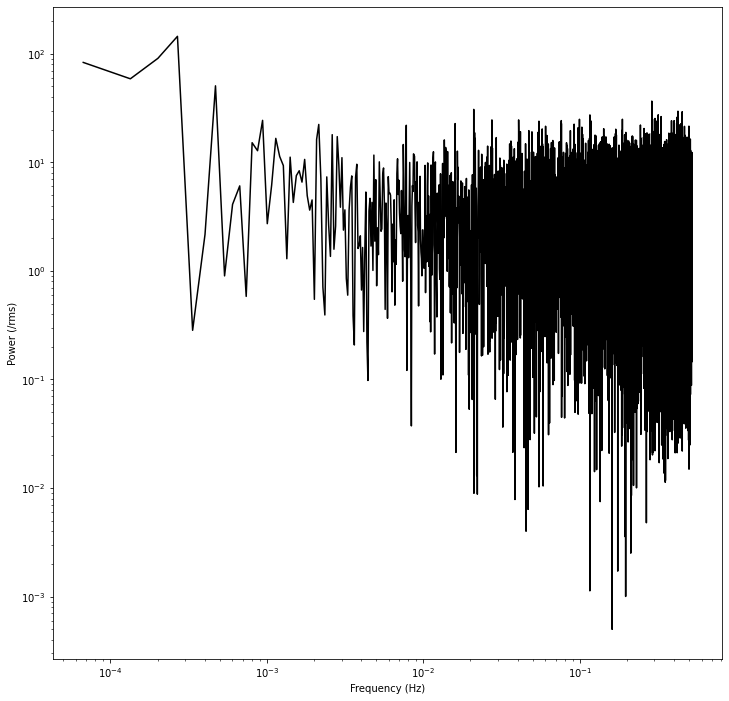

In [3]:
apsd = AveragedPowerspectrum(lcs[0],segment_size=max_gti)
fig, axs = plt.subplots(1,1)
axs.loglog(apsd.freq,apsd.power,color='k')
axs.set_xlabel('Frequency (Hz)')
axs.set_ylabel('Power (/rms)')
plt.show()

/home/rwebbe/.local/lib/python3.8/site-packages/stingray/lightcurve.py:408: RuntimeWarning: invalid value encountered in multiply
  counts_err = self._countrate_err * self.dt
1it [00:00, 730.71it/s]


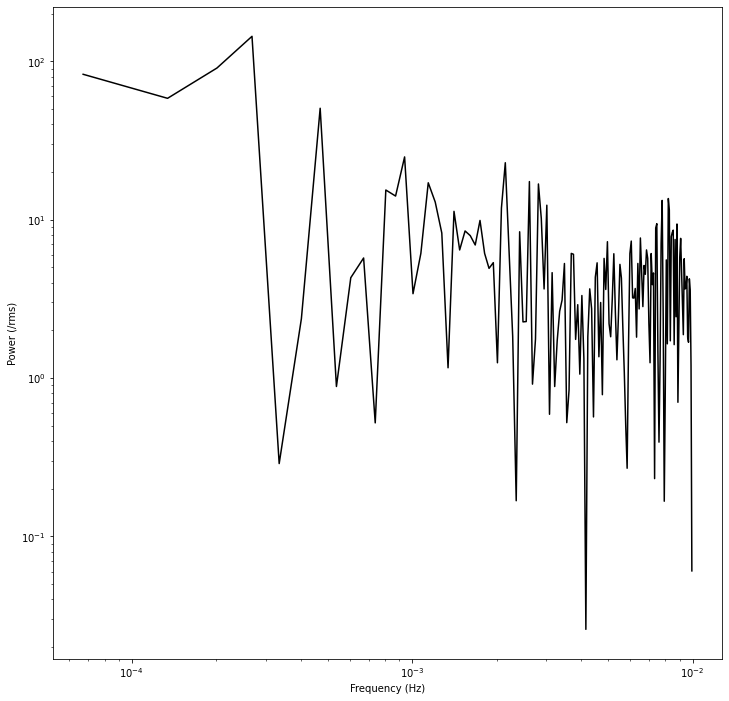

In [4]:
apsd = AveragedPowerspectrum(lcs[0].rebin(50),segment_size=max_gti)
fig, axs = plt.subplots(1,1)
axs.loglog(apsd.freq,apsd.power,color='k')
axs.set_xlabel('Frequency (Hz)')
axs.set_ylabel('Power (/rms)')
plt.show()

In [5]:
from stingray.pulse.pulsar import fold_events
from stingray.pulse.search import plot_profile
from stingray.pulse.search import epoch_folding_search, z_n_search
from stingray.gti import create_gti_mask

pn_events = st.EventList.read(evt_names[0],fmt_='hea',skip_checks=True)
pn_events.gti = pn_gtis
pn_gti_mask = create_gti_mask(pn_events.time,pn_gtis)
pn_times = pn_events.time[pn_gti_mask]
clean_pn_events = st.EventList(pn_times, pi=pn_events.pi[pn_gti_mask])
clean_pn_events.filter_energy_range([200,12000],inplace=True,use_pi=True)

m1hdul = fits.open('prev_obs/pps/P0840910501M1X000SRCTSR8001.FTZ')
m1_gtis = []
for i in m1hdul['SRC_GTIS'].data:
    m1_gtis.append([i[0],i[1]])
m1_events = st.EventList.read(evt_names[1],fmt_='hea',skip_checks=True)
m1_events.gti = m1_gtis
m1_gti_mask = create_gti_mask(m1_events.time,m1_gtis)
m1_times = m1_events.time[m1_gti_mask]
clean_m1_events = st.EventList(m1_times, pi=m1_events.pi[m1_gti_mask])
clean_m1_events.filter_energy_range([200,12000],inplace=True,use_pi=True)

m2hdul = fits.open('prev_obs/pps/P0840910501M2X000SRCTSR8001.FTZ')
m2_gtis = []
for i in m2hdul['SRC_GTIS'].data:
    m2_gtis.append([i[0],i[1]])
m2_events = st.EventList.read(evt_names[2],fmt_='hea',skip_checks=True)
m2_events.gti = m2_gtis
m2_gti_mask = create_gti_mask(m2_events.time,m2_gtis)
m2_times = m2_events.time[m2_gti_mask]
clean_m2_events = st.EventList(m2_times, pi=m2_events.pi[m2_gti_mask])
clean_m2_events.filter_energy_range([200,12000],inplace=True,use_pi=True)

clean_mos_evts = clean_m1_events.join(clean_m2_events)
clean_allevts = clean_mos_evts.join(clean_pn_events)

/home/rwebbe/.local/lib/python3.8/site-packages/stingray/base.py:1226: UserWarning: The time array is not sorted. Sorting it now.
  warnings.warn("The time array is not sorted. Sorting it now.")


In [6]:
t0 = pn_gtis[0][0]
print(np.asarray(clean_allevts.gti) - t0)
print(np.asarray(pn_gtis) - t0)
print(np.asarray(m1_gtis) - t0)
print(np.asarray(m2_gtis) - t0)

[[-2495.68875706 15924.07293177]]
[[    0.         14915.5200001 ]
 [14971.20000005 15183.36000013]
 [15239.04000008 15563.5200001 ]]
[[-2518.787498 15931.212502]]
[[-2497.39170504 15922.60829496]]


In [7]:
from stingray.pulse.search import search_best_peaks
from stingray.stats import fold_detection_level, z2_n_detection_level

obs_length = max(clean_allevts.time) - min(clean_allevts.time)
df_min = 1/obs_length
oversampling=15
df = df_min / oversampling
frequencies = np.arange(2*df_min, 5, df)

freq, efstat = epoch_folding_search(clean_allevts.time, frequencies, nbin=32, gti=pn_gtis)
freq, zstat = z_n_search(clean_allevts.time, frequencies, nbin=32, nharm=1, gti=pn_gtis)

ntrial = (frequencies[-1] - frequencies[0]) / df_min
z_detlev = z2_n_detection_level(n=1, epsilon=0.001, ntrial=len(freq))
ef_detlev = fold_detection_level(32, epsilon=0.001, ntrial=len(freq))

cand_freqs_ef, cand_stat_ef = search_best_peaks(freq, efstat, ef_detlev)
cand_freqs_z, cand_stat_z = search_best_peaks(freq, zstat, z_detlev)

In [8]:
print(len(cand_freqs_ef))
print(len(cand_freqs_z))

21
6


In [9]:
for i in sorted(cand_freqs_ef)[:19]:
    print(cand_freqs_ef[cand_freqs_ef == i],1/i,cand_stat_ef[cand_freqs_ef == i])

[0.00010858] 9209.880844414234 [1315.20650037]
[0.00051394] 1945.7494741720202 [140.65339091]
[0.0005248] 1905.4925884994957 [107.66515017]
[0.00053204] 1879.56751926821 [120.92558893]
[0.00057185] 1748.711552736879 [144.39908239]
[0.00058995] 1695.0700940639683 [115.55627096]
[0.0006008] 1664.4362971832943 [104.36361183]
[0.00061166] 1634.8900907244195 [105.50607241]
[0.0006189] 1615.7685691954787 [105.79723946]
[0.00064062] 1560.9967532905473 [123.5954428]
[0.00067681] 1477.5209910824965 [108.35605506]
[0.000713] 1402.519925545314 [123.51401473]
[0.00078901] 1267.4147951028756 [112.16836951]
[0.00086501] 1156.0519888386061 [162.74754212]
[0.00088673] 1127.740511560926 [108.32891236]
[0.00090483] 1105.1857013297074 [123.42024907]
[0.00094826] 1054.5665089023926 [129.3941088]
[0.0011256] 888.4129431910832 [140.38689902]
[0.0011437] 874.3557763684395 [104.53140301]


In [10]:
for i in sorted(cand_freqs_z):
    print(cand_freqs_z[cand_freqs_z == i],1/i,cand_stat_z[cand_freqs_z == i])

[0.00010858] 9209.880844414234 [975.73630608]
[0.00024611] 4063.1827254768664 [568.40292892]
[0.00041984] 2381.86573562437 [152.357129]
[0.00052842] 1892.441269400184 [50.03980063]
[0.0009193] 1087.7812020961687 [71.18192261]
[0.0011256] 888.4129431910832 [63.5255801]


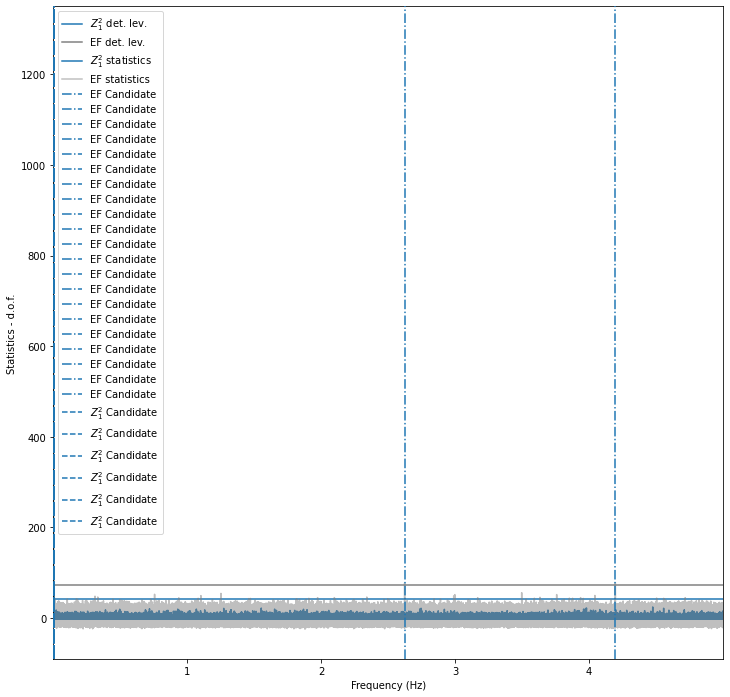

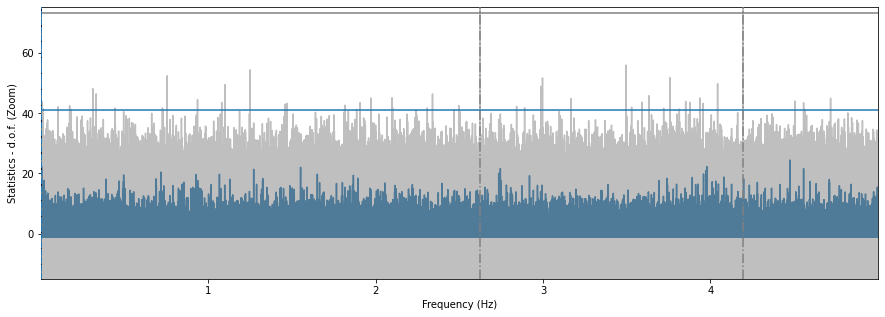

In [11]:
nharm=1
nbin=32
plt.figure()
plt.axhline(z_detlev - nharm, label='$Z^2_1$ det. lev.')
plt.axhline(ef_detlev - nbin + 1, label='EF det. lev.', color='gray')

plt.plot(freq, (zstat - nharm), label='$Z^2_1$ statistics')
plt.plot(freq, efstat - nbin + 1, color='gray', label='EF statistics', alpha=0.5)

for c in cand_freqs_ef:
    plt.axvline(c, ls='-.', label='EF Candidate', zorder=10)
for c in cand_freqs_z:
    plt.axvline(c, ls='--', label='$Z^2_1$ Candidate', zorder=10)

#plt.axvline(1/period, color='r', lw=3, alpha=0.5, label='Correct frequency')
plt.xlim([frequencies[0], frequencies[-1]])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Statistics - d.o.f.')
plt.legend()

plt.figure(figsize=(15, 5))
plt.plot(freq, (zstat - nharm), label='$Z_2$ statistics')
plt.plot(freq, efstat - nbin + 1, color='gray', label='EF statistics', alpha=0.5)

#plt.axvline(1/period, color='r', lw=3, alpha=0.5, label='Correct frequency')
plt.axhline(z_detlev - nharm, label='$Z^2_1$ det. lev.', zorder=10)
plt.axhline(ef_detlev - nbin + 1, label='EF det. lev.', color='gray', zorder=10)

for c in cand_freqs_ef:
    plt.axvline(c, ls='-.', label='EF Candidate', color='gray', zorder=10)
for c in cand_freqs_z:
    plt.axvline(c, ls='--', label='$Z^2_1$ Candidate', zorder=10)

plt.xlabel('Frequency (Hz)')
plt.ylabel('Statistics - d.o.f. (Zoom)')

plt.ylim([-15, ef_detlev - nbin + 3])
_ = plt.xlim([frequencies[0], frequencies[-1]])

In [12]:
for cand_f in sorted(cand_freqs_ef[np.where(cand_freqs_ef < 0.5)[0]]):
    print(cand_freqs_ef[cand_freqs_ef == cand_f],1/cand_freqs_ef[cand_freqs_ef == cand_f],cand_stat_ef[cand_freqs_ef == cand_f])


[0.00010858] [9209.88084441] [1315.20650037]
[0.00051394] [1945.74947417] [140.65339091]
[0.0005248] [1905.4925885] [107.66515017]
[0.00053204] [1879.56751927] [120.92558893]
[0.00057185] [1748.71155274] [144.39908239]
[0.00058995] [1695.07009406] [115.55627096]
[0.0006008] [1664.43629718] [104.36361183]
[0.00061166] [1634.89009072] [105.50607241]
[0.0006189] [1615.7685692] [105.79723946]
[0.00064062] [1560.99675329] [123.5954428]
[0.00067681] [1477.52099108] [108.35605506]
[0.000713] [1402.51992555] [123.51401473]
[0.00078901] [1267.4147951] [112.16836951]
[0.00086501] [1156.05198884] [162.74754212]
[0.00088673] [1127.74051156] [108.32891236]
[0.00090483] [1105.18570133] [123.42024907]
[0.00094826] [1054.5665089] [129.3941088]
[0.0011256] [888.41294319] [140.38689902]
[0.0011437] [874.35577637] [104.53140301]


In [13]:
for cand_f in sorted(cand_freqs_z[np.where(cand_freqs_z < 0.5)[0]]):
    print(cand_freqs_z[cand_freqs_z == cand_f],1 / cand_freqs_z[cand_freqs_z == cand_f],cand_stat_z[cand_freqs_z == cand_f])
    

[0.00010858] [9209.88084441] [975.73630608]
[0.00024611] [4063.18272548] [568.40292892]
[0.00041984] [2381.86573562] [152.357129]
[0.00052842] [1892.4412694] [50.03980063]
[0.0009193] [1087.7812021] [71.18192261]
[0.0011256] [888.41294319] [63.5255801]


9209.799226376865


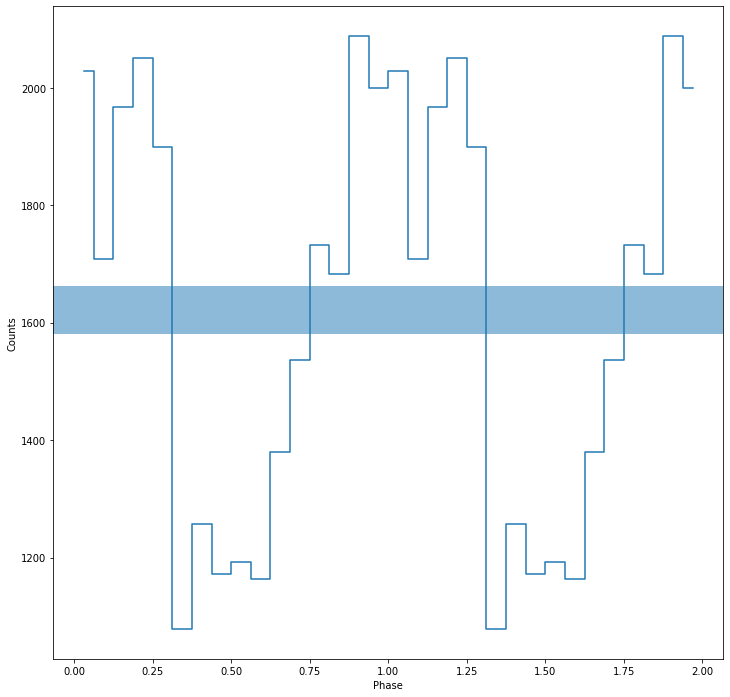

In [14]:
f0 = 0.00010858
P = 1 / f0
print(P)
ph, profile, profile_err = fold_events(clean_allevts.time, f0)
_ = plot_profile(ph,profile)

1945.7524224617662


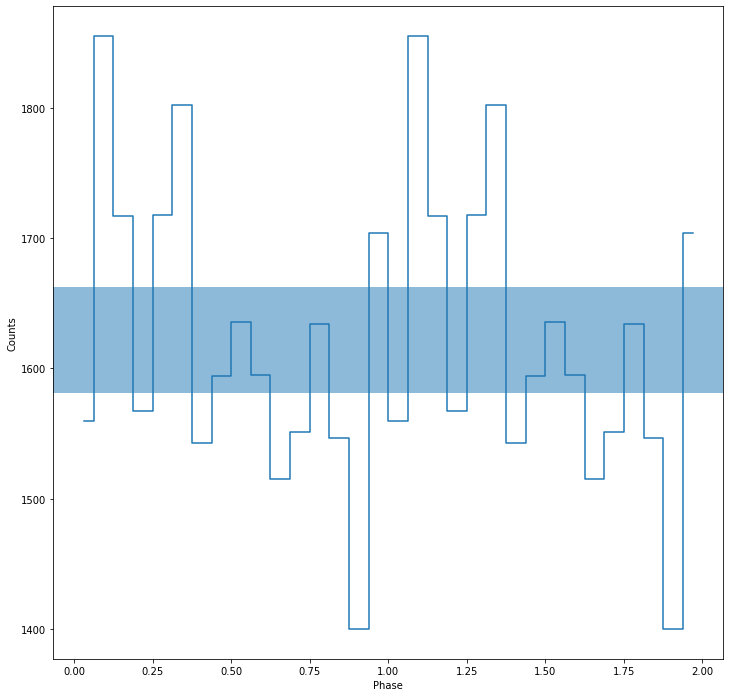

In [15]:
f0 = 0.00051394
P = 1 / f0
print(P)
ph, profile, profile_err = fold_events(clean_allevts.time, f0)
_ = plot_profile(ph,profile)

1748.7103261344757


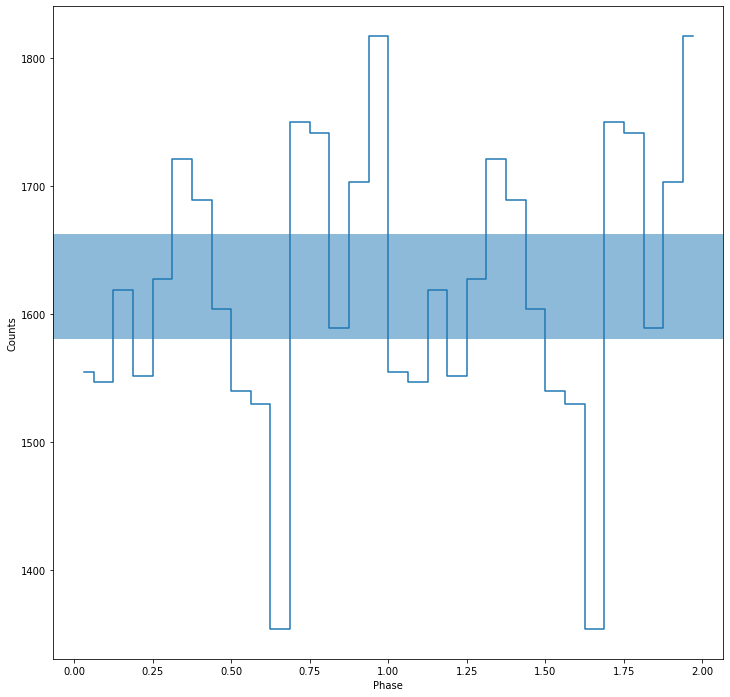

In [16]:
f0 = 0.00057185
P = 1 / f0
print(P)
ph, profile, profile_err = fold_events(clean_allevts.time, f0)
_ = plot_profile(ph,profile)

1156.0559993526085


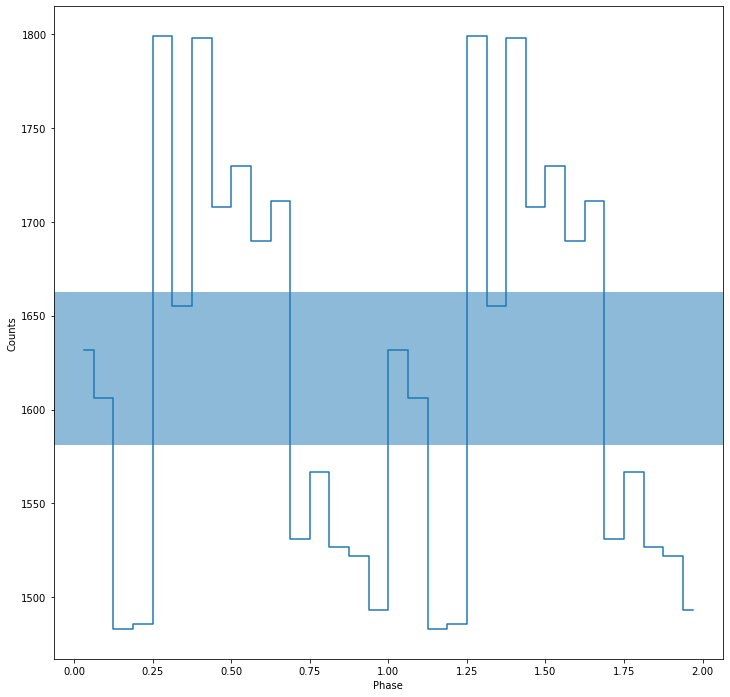

In [17]:
f0 = 0.00086501
P = 1 / f0
print(P)
ph, profile, profile_err = fold_events(clean_allevts.time, f0)
_ = plot_profile(ph,profile)

1054.5630945099444


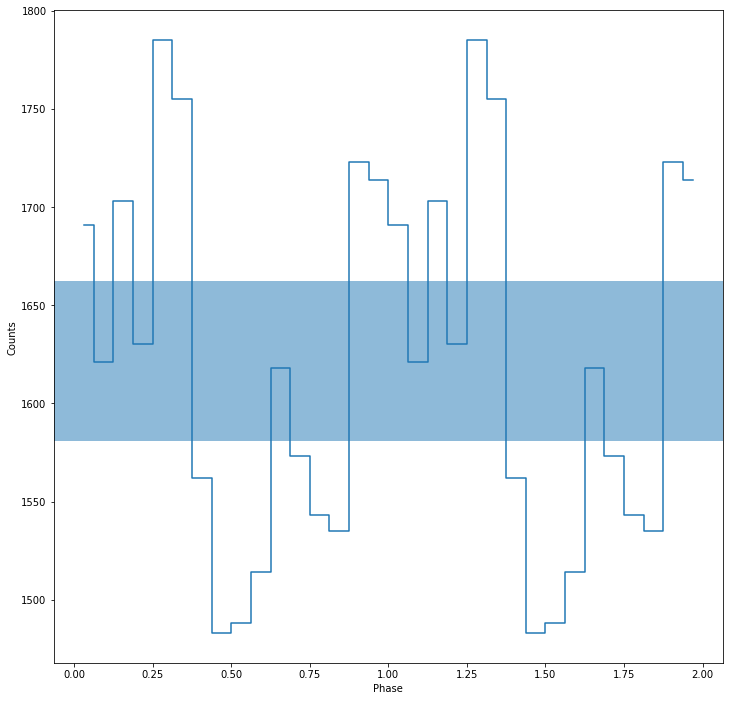

In [18]:
f0 = 0.00094826
P = 1 / f0
print(P)
ph, profile, profile_err = fold_events(clean_allevts.time, f0)
_ = plot_profile(ph,profile)

888.4150675195451


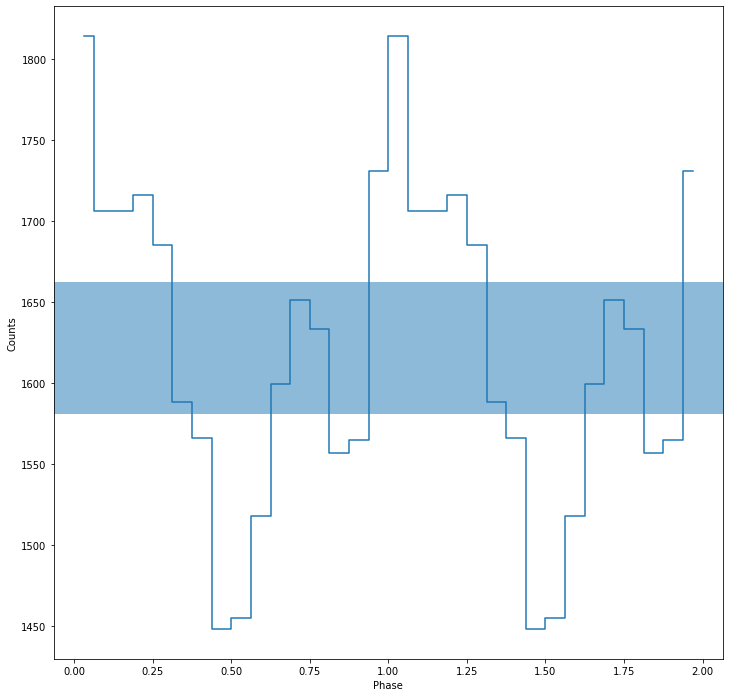

In [19]:
f0 = 0.0011256
P = 1 / f0
print(P)
ph, profile, profile_err = fold_events(clean_allevts.time, f0)
_ = plot_profile(ph,profile)

9209.799226376865


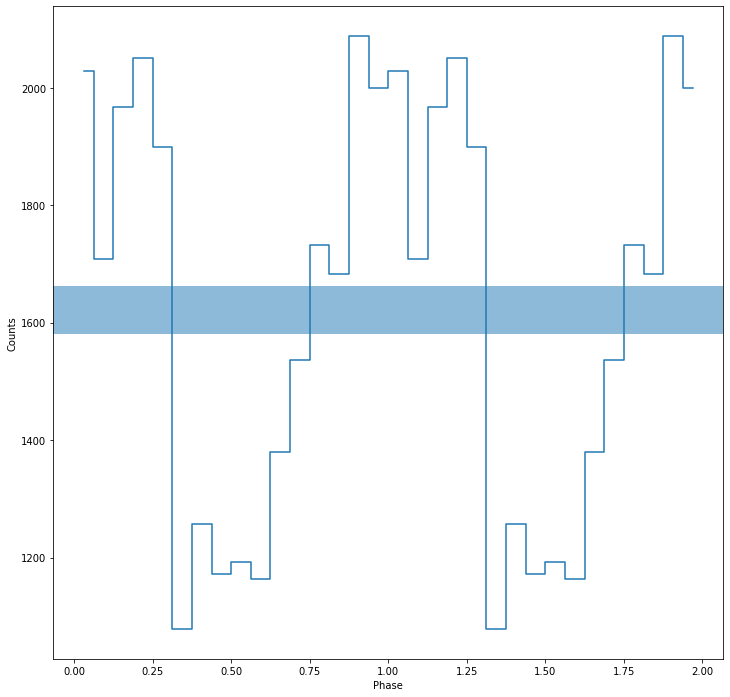

In [20]:
f0 = 0.00010858
P = 1 / f0
print(P)
ph, profile, profile_err = fold_events(clean_allevts.time, f0)
_ = plot_profile(ph,profile)

4063.223761732558


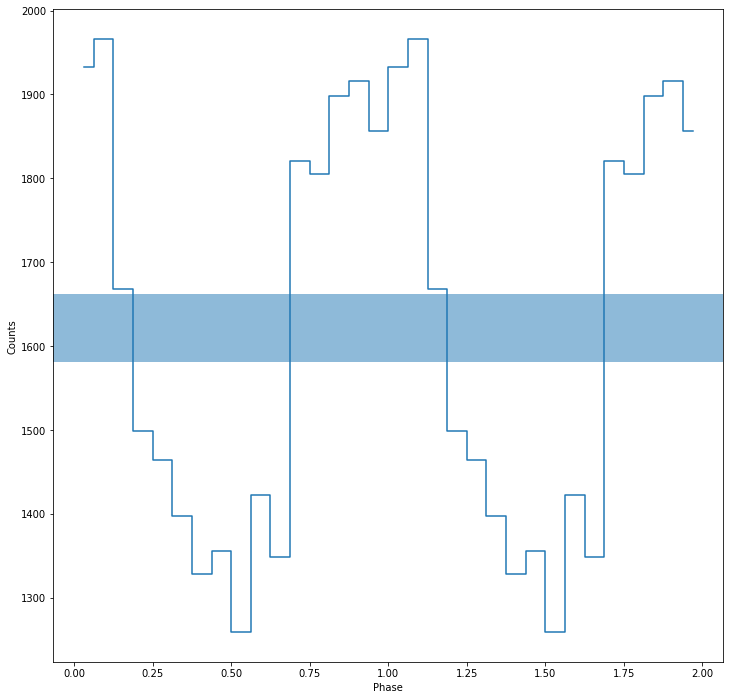

In [21]:
f0 = 0.00024611
P = 1 / f0
print(P)
ph, profile, profile_err = fold_events(clean_allevts.time, f0)
_ = plot_profile(ph,profile)

2381.859756097561


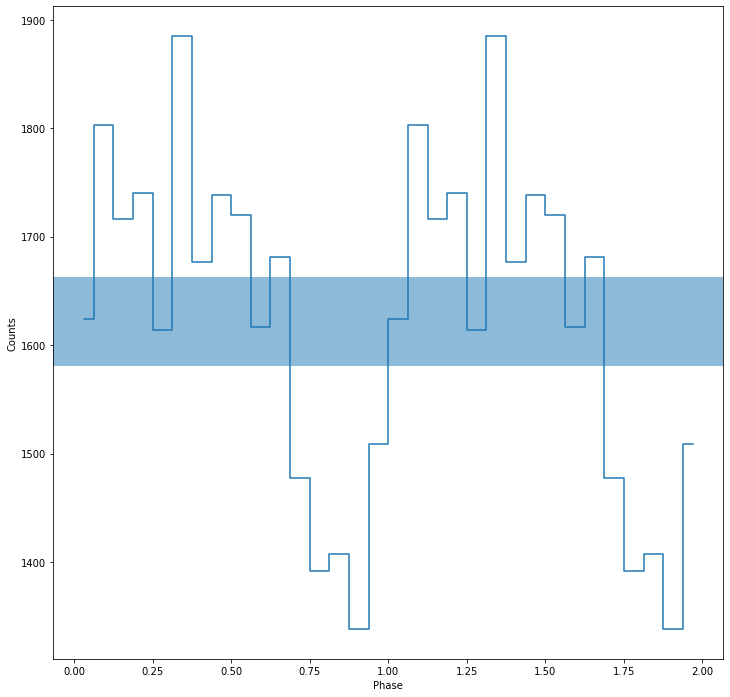

In [22]:
f0 = 0.00041984
P = 1 / f0
print(P)
ph, profile, profile_err = fold_events(clean_allevts.time, f0)
_ = plot_profile(ph,profile)

In [23]:
print(obs_length) 

18419.76168882847


In [24]:
profile_err

array([40.29888336, 42.46174749, 41.42463035, 41.71330723, 40.17461885,
       43.41658669, 40.95119046, 41.68932717, 41.47288271, 40.21193853,
       41.        , 38.4317577 , 37.30951621, 37.50999867, 36.57868232,
       38.8458492 ])

In [25]:
ph_out = np.concatenate((ph,ph+1))
profile_out = np.concatenate((profile,profile))
prof_err_out = np.concatenate((profile_err,profile_err))

In [26]:
np.savetxt('src1_pulse_profile.csv',(ph_out, profile_out,prof_err_out),delimiter=',')

In [27]:
from astropy.stats import poisson_conf_interval

In [28]:
err_low, err_high = poisson_conf_interval(np.mean(profile), interval="frequentist-confidence", sigma=1)
print(np.mean(profile),err_low, err_high)

1621.125 1580.8659474712204 1662.3964793161695


In [29]:
err_low, err_high = poisson_conf_interval(np.mean(profile), interval="frequentist-confidence", sigma=3)
print(np.mean(profile),err_low, err_high)

1621.125 1502.997713497693 1745.62242605029


In [30]:
err_low, err_high = poisson_conf_interval(np.mean(profile), interval="frequentist-confidence", sigma=5)
print(np.mean(profile),err_low, err_high)

1621.125 1427.745353796641 1831.5636119343799
